# **Project: Amazon Product Recommendation System**

# **Marks: 40**


Welcome to the project on Recommendation Systems. We will work with the Amazon product reviews dataset for this project. The dataset contains ratings of different electronic products. It does not include information about the products or reviews to avoid bias while building the model.

--------------
## **Context:**
--------------

Today, information is growing exponentially with volume, velocity and variety throughout the globe. This has lead to information overload, and too many choices for the consumer of any business. It represents a real dilemma for these consumers and they often turn to denial. Recommender Systems are one of the best tools that help recommending products to consumers while they are browsing online. Providing personalized recommendations which is most relevant for the user is what's most likely to keep them engaged and help business.

E-commerce websites like Amazon, Walmart, Target and Etsy use different recommendation models to provide personalized suggestions to different users. These companies spend millions of dollars to come up with algorithmic techniques that can provide personalized recommendations to their users.

Amazon, for example, is well-known for its accurate selection of recommendations in its online site. Amazon's recommendation system is capable of intelligently analyzing and predicting customers' shopping preferences in order to offer them a list of recommended products. Amazon's recommendation algorithm is therefore a key element in using AI to improve the personalization of its website. For example, one of the baseline recommendation models that Amazon uses is item-to-item collaborative filtering, which scales to massive data sets and produces high-quality recommendations in real-time.

----------------
## **Objective:**
----------------

You are a Data Science Manager at Amazon, and have been given the task of building a recommendation system to recommend products to customers based on their previous ratings for other products. You have a collection of labeled data of Amazon reviews of products. The goal is to extract meaningful insights from the data and build a recommendation system that helps in recommending products to online consumers.

-----------------------------
## **Dataset:**
-----------------------------

The Amazon dataset contains the following attributes:

- **userId:** Every user identified with a unique id
- **productId:** Every product identified with a unique id
- **Rating:** The rating of the corresponding product by the corresponding user
- **timestamp:** Time of the rating. We **will not use this column** to solve the current problem

**Note:** The code has some user defined functions that will be usefull while making recommendations and measure model performance, you can use these functions or can create your own functions.

Sometimes, the installation of the surprise library, which is used to build recommendation systems, faces issues in Jupyter. To avoid any issues, it is advised to use **Google Colab** for this project.

Let's start by mounting the Google drive on Colab.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Installing surprise library**

In [ ]:
!pip install surprise

## **Importing the necessary libraries and overview of the dataset**

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
from collections import defaultdict
import warnings
warnings.filterwarnings('ignore')

### **Loading the data**
- Import the Dataset
- Add column names ['user_id', 'prod_id', 'rating', 'timestamp']
- Drop the column timestamp
- Copy the data to another DataFrame called **df**

In [ ]:
# Import dataset
data = pd.read_csv('/content/ratings_Electronics.csv')

In [ ]:
# Add column names['user_id', 'prod_id', 'rating', 'timestamp']
data.columns = ['user_id', 'prod_id', 'rating', 'timestamp']

In [ ]:
# Drop the column timestamp
data = data.drop('timestamp', axis = 1) # Dropping timestamp

In [ ]:
#Copy the data to another DataFrame called df
df = data.copy(deep = True)

In [ ]:
# Show 5 data entries
df.head()

,user_id,prod_id,rating
0,A2CX7LUOHB2NDG,0321732944,5.0
1,A2NWSAGRHCP8N5,0439886341,1.0
2,A2WNBOD3WNDNKT,0439886341,3.0
3,A1GI0U4ZRJA8WN,0439886341,1.0
4,A1QGNMC6O1VW39,0511189877,5.0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7824481 entries, 0 to 7824480
Data columns (total 3 columns):
 #   Column   Dtype  
---  ------   -----  
 0   user_id  object 
 1   prod_id  object 
 2   rating   float64
dtypes: float64(1), object(2)
memory usage: 179.1+ MB


**As this dataset is very large and has 7,824,482 observations, it is not computationally possible to build a model using this. Moreover, many users have only rated a few products and also some products are rated by very few users. Hence, we can reduce the dataset by considering certain logical assumptions.**

Here, we will be taking users who have given at least 50 ratings, and the products that have at least 5 ratings, as when we shop online we prefer to have some number of ratings of a product.

In [ ]:
# Get the column containing the users
users = df.user_id

# Create a dictionary from users to their number of ratings
ratings_count = dict()

for user in users:

    # If we already have the user, just add 1 to their rating count
    if user in ratings_count:
        ratings_count[user] += 1

    # Otherwise, set their rating count to 1
    else:
        ratings_count[user] = 1

In [ ]:
# We want our users to have at least 50 ratings to be considered
RATINGS_CUTOFF = 50

remove_users = []

for user, num_ratings in ratings_count.items():
    if num_ratings < RATINGS_CUTOFF:
        remove_users.append(user)

df = df.loc[ ~ df.user_id.isin(remove_users)]

In [ ]:
# Get the column containing the products
prods = df.prod_id

# Create a dictionary from products to their number of ratings
ratings_count = dict()

for prod in prods:

    # If we already have the product, just add 1 to its rating count
    if prod in ratings_count:
        ratings_count[prod] += 1

    # Otherwise, set their rating count to 1
    else:
        ratings_count[prod] = 1

In [ ]:
# We want our item to have at least 5 ratings to be considered
RATINGS_CUTOFF = 5

remove_users = []

for user, num_ratings in ratings_count.items():
    if num_ratings < RATINGS_CUTOFF:
        remove_users.append(user)

df_final = df.loc[~ df.prod_id.isin(remove_users)]

In [ ]:
# Print a few rows of the imported dataset
df_final.head()

,user_id,prod_id,rating
1309,A3LDPF5FMB782Z,1400501466,5.0
1321,A1A5KUIIIHFF4U,1400501466,1.0
1334,A2XIOXRRYX0KZY,1400501466,3.0
1450,AW3LX47IHPFRL,1400501466,5.0
1455,A1E3OB6QMBKRYZ,1400501466,1.0


## **Exploratory Data Analysis**

### **Shape of the data**

### **Check the number of rows and columns and provide observations.**

In [ ]:
# Check the number of rows and columns and provide observations
rows, columns = df_final.shape
print("No of rows: ", rows)
print("No of columns: ", columns)

No of rows:  65290
No of columns:  3


**Write your observations here: There are 65290 rows (entries) with >= 50 rating, and there are 3 columns (attributes) user_id, prod_id and rating**

### **Data types**

In [ ]:
# Check Data types and provide observations
df_final.dtypes

,0
user_id,object
prod_id,object
rating,float64


**Write your observations here: user_id and prod_id are object type, while rating is a 64 bits double data type**

### **Checking for missing values**

In [ ]:
# Check for missing values present and provide observations
df_final.isnull().sum()

,0
user_id,0
prod_id,0
rating,0


**Write your observations here:There is no missing values**

### **Summary Statistics**

In [ ]:
# Summary statistics of 'rating' variable and provide observations
round(df_final['rating'].describe(), 3)

,rating
count,65290.000
mean,4.295
std,0.989
min,1.000
25%,4.000
50%,5.000
75%,5.000
max,5.000


**Write your observations here:There are 65290 entries with mean rating of 4.295, Q1 = 4, Q2 = 5, and standard deviation = 0.989. The max rating is 5 and the min rating is 1.**

### **Checking the rating distribution**

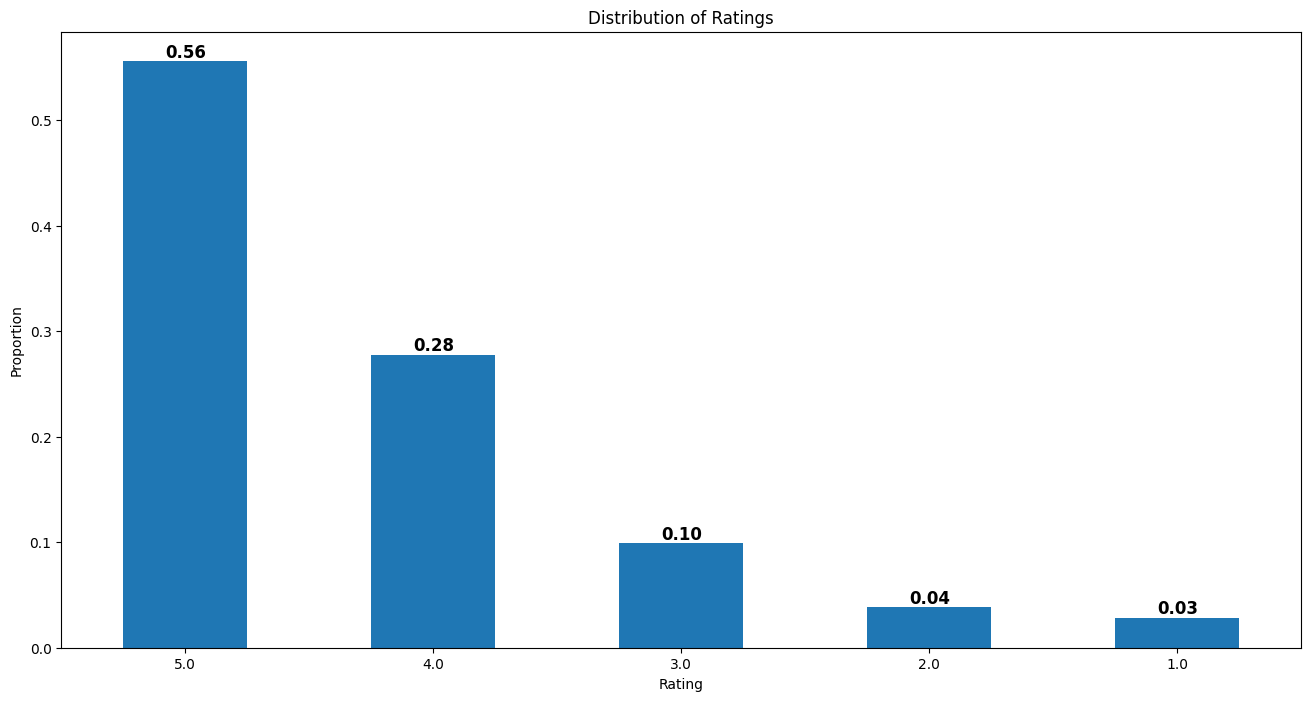

In [ ]:
# Create the bar plot and provide observations
plt.figure(figsize=(16, 8))
ax = df_final['rating'].value_counts(1).plot(kind='bar')

# Ensure x labels are shown horizontally
ax.set_xticklabels(ax.get_xticklabels(), rotation=0, ha="center")

# Add value labels on top of each bar
for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}',
                (p.get_x() + p.get_width() / 2, p.get_height()),
                ha='center', va='bottom', fontsize=12, fontweight='bold')

plt.xlabel("Rating")
plt.ylabel("Proportion")
plt.title("Distribution of Ratings")
plt.show()

**Write your observations here: "5.0" has the highest propotion of rating with 56%, whith "4.0" lies at the second of 28%. The rating for equal and below "3.0" accounts for 17% of total number of rating. It shows that a large proportion of user (84%) are satisfied with the system**

### **Checking the number of unique users and items in the dataset**

In [ ]:
# Number of total rows in the data and number of unique user id and product id in the data
print('Total observations: ', len(df_final))
print('Number of unique Users: ', df_final['user_id'].count())
print('Number of unique Items: ', df_final['prod_id'].count())


Total observations:  65290
Number of unique Users:  65290
Number of unique Items:  65290


**Write your observations here:There is no duplication in the data**

### **Users with the most number of ratings**

In [ ]:
# Top 10 users based on the number of ratings
top_10 = df_final.groupby('user_id').size().sort_values(ascending=False).to_frame(name='count')[:10]
print("Top 10 users based on the number of ratings")
top_10


Top 10 users based on the number of ratings


,count
user_id,
ADLVFFE4VBT8,295
A3OXHLG6DIBRW8,230
A1ODOGXEYECQQ8,217
A36K2N527TXXJN,212
A25C2M3QF9G7OQ,203
A680RUE1FDO8B,196
A22CW0ZHY3NJH8,193
A1UQBFCERIP7VJ,193
AWPODHOB4GFWL,184


**Write your observations here:The top 10 users have a significantly higher number of ratings compared to others, with the highest contributor (ADLVFFE4VBT8) having 295 ratings. The distribution suggests that a small group of users might be responsible for a large portion of the ratings.**

**Now that we have explored and prepared the data, let's build the first recommendation system.**

## **Model 1: Rank Based Recommendation System**

In [ ]:
# Calculate the average rating for each product
avg_rating = df_final.groupby('prod_id')['rating'].mean()

# Calculate the count of ratings for each product
rating_count = df_final.groupby('prod_id')['rating'].count()

# Create a dataframe with calculated average and count of ratings
final_rating = pd.DataFrame({'avg_rating': avg_rating, 'rating_count': rating_count})

# Sort the dataframe by average of ratings in the descending order
final_rating.sort_values('avg_rating', ascending = False, inplace = True)


# See the first five records of the "final_rating" dataset
final_rating.head()

,avg_rating,rating_count
prod_id,,
B00LGQ6HL8,5.0,5
B003DZJQQI,5.0,14
B005FDXF2C,5.0,7
B00I6CVPVC,5.0,7
B00B9KOCYA,5.0,8


In [ ]:
# Defining a function to get the top n products based on the highest average rating and minimum interactions
def top_n_products(final_rating, n, min_interaction):

    # Finding products with minimum number of interactions
    recommendations = final_rating[final_rating['rating_count'] > min_interaction]

    # Sorting values with respect to average rating
    recommendations = recommendations.sort_values('avg_rating', ascending = False)

    return recommendations.index[:n]


### **Recommending top 5 products with 50 minimum interactions based on popularity**

In [ ]:
top_5_products = top_n_products(final_rating, 5, 50)

#Retrieve interaction counts
interaction_counts = final_rating.loc[top_5_products, 'rating_count']

# Format output
formatted_output = ', '.join([f"{product} - ({interaction_counts[product]})" for product in top_5_products])

print(f"Top 5 Products with 50 minimum interactions: {formatted_output}")

Top 5 Products with 50 minimum interactions: B001TH7GUU - (78), B003ES5ZUU - (184), B0019EHU8G - (90), B006W8U2MU - (57), B000QUUFRW - (84)


### **Recommending top 5 products with 100 minimum interactions based on popularity**

In [ ]:
top_5_products = top_n_products(final_rating, 5, 100)

#Retrieve interaction counts
interaction_counts = final_rating.loc[top_5_products, 'rating_count']

# Format output
formatted_output = ', '.join([f"{product} - ({interaction_counts[product]})" for product in top_5_products])

print(f"Top 5 Products with 100 minimum interactions: {formatted_output}")

Top 5 Products with 100 minimum interactions: B003ES5ZUU - (184), B000N99BBC - (167), B007WTAJTO - (164), B002V88HFE - (106), B004CLYEDC - (118)


We have recommended the **top 5** products by using the popularity recommendation system. Now, let's build a recommendation system using **collaborative filtering.**

## **Model 2: Collaborative Filtering Recommendation System**

### **Building a baseline user-user similarity based recommendation system**

- Below, we are building **similarity-based recommendation systems** using `cosine` similarity and using **KNN to find similar users** which are the nearest neighbor to the given user.  
- We will be using a new library, called `surprise`, to build the remaining models. Let's first import the necessary classes and functions from this library.

In [ ]:
# To compute the accuracy of models
from surprise import accuracy

# Class is used to parse a file containing ratings, data should be in structure - user ; item ; rating
from surprise.reader import Reader

# Class for loading datasets
from surprise.dataset import Dataset

# For tuning model hyperparameters
from surprise.model_selection import GridSearchCV

# For splitting the rating data in train and test datasets
from surprise.model_selection import train_test_split

# For implementing similarity-based recommendation system
from surprise.prediction_algorithms.knns import KNNBasic

# For implementing matrix factorization based recommendation system
from surprise.prediction_algorithms.matrix_factorization import SVD

# for implementing K-Fold cross-validation
from surprise.model_selection import KFold

# For implementing clustering-based recommendation system
from surprise import CoClustering

**Before building the recommendation systems, let's  go over some basic terminologies we are going to use:**

**Relevant item:** An item (product in this case) that is actually **rated higher than the threshold rating** is relevant, if the **actual rating is below the threshold then it is a non-relevant item**.  

**Recommended item:** An item that's **predicted rating is higher than the threshold is a recommended item**, if the **predicted rating is below the threshold then that product will not be recommended to the user**.  


**False Negative (FN):** It is the **frequency of relevant items that are not recommended to the user**. If the relevant items are not recommended to the user, then the user might not buy the product/item. This would result in the **loss of opportunity for the service provider**, which they would like to minimize.

**False Positive (FP):** It is the **frequency of recommended items that are actually not relevant**. In this case, the recommendation system is not doing a good job of finding and recommending the relevant items to the user. This would result in **loss of resources for the service provider**, which they would also like to minimize.

**Recall:** It is the **fraction of actually relevant items that are recommended to the user**, i.e., if out of 10 relevant products, 6 are recommended to the user then recall is 0.60. Higher the value of recall better is the model. It is one of the metrics to do the performance assessment of classification models.

**Precision:** It is the **fraction of recommended items that are relevant actually**, i.e., if out of 10 recommended items, 6 are found relevant by the user then precision is 0.60. The higher the value of precision better is the model. It is one of the metrics to do the performance assessment of classification models.

**While making a recommendation system, it becomes customary to look at the performance of the model. In terms of how many recommendations are relevant and vice-versa, below are some most used performance metrics used in the assessment of recommendation systems.**

### **Precision@k, Recall@ k, and F1-score@k**

**Precision@k** - It is the **fraction of recommended items that are relevant in `top k` predictions**. The value of k is the number of recommendations to be provided to the user. One can choose a variable number of recommendations to be given to a unique user.  


**Recall@k** - It is the **fraction of relevant items that are recommended to the user in `top k` predictions**.

**F1-score@k** - It is the **harmonic mean of Precision@k and Recall@k**. When **precision@k and recall@k both seem to be important** then it is useful to use this metric because it is representative of both of them.

### **Some useful functions**

- Below function takes the **recommendation model** as input and gives the **precision@k, recall@k, and F1-score@k** for that model.  
- To compute **precision and recall**, **top k** predictions are taken under consideration for each user.
- We will use the precision and recall to compute the F1-score.

In [ ]:
def precision_recall_at_k(model, k = 10, threshold = 3.5):
    """Return precision and recall at k metrics for each user"""

    # First map the predictions to each user
    user_est_true = defaultdict(list)

    # Making predictions on the test data
    predictions = model.test(testset)

    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))

    precisions = dict()
    recalls = dict()
    for uid, user_ratings in user_est_true.items():

        # Sort user ratings by estimated value
        user_ratings.sort(key = lambda x: x[0], reverse = True)

        # Number of relevant items
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)

        # Number of recommended items in top k
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])

        # Number of relevant and recommended items in top k
        n_rel_and_rec_k = sum(((true_r >= threshold) and (est >= threshold))
                              for (est, true_r) in user_ratings[:k])

        # Precision@K: Proportion of recommended items that are relevant
        # When n_rec_k is 0, Precision is undefined. Therefore, we are setting Precision to 0 when n_rec_k is 0

        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 0

        # Recall@K: Proportion of relevant items that are recommended
        # When n_rel is 0, Recall is undefined. Therefore, we are setting Recall to 0 when n_rel is 0

        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 0

    # Mean of all the predicted precisions are calculated.
    precision = round((sum(prec for prec in precisions.values()) / len(precisions)), 3)

    # Mean of all the predicted recalls are calculated.
    recall = round((sum(rec for rec in recalls.values()) / len(recalls)), 3)

    accuracy.rmse(predictions)

    print('Precision: ', precision) # Command to print the overall precision

    print('Recall: ', recall) # Command to print the overall recall

    print('F_1 score: ', round((2*precision*recall)/(precision+recall), 3)) # Formula to compute the F-1 score

**Hints:**

- To compute **precision and recall**, a **threshold of 3.5 and k value of 10 can be considered for the recommended and relevant ratings**.
- Think about the performance metric to choose.

Below we are loading the **`rating` dataset**, which is a **pandas DataFrame**, into a **different format called `surprise.dataset.DatasetAutoFolds`**, which is required by this library. To do this, we will be **using the classes `Reader` and `Dataset`.**

In [ ]:
# Instantiating Reader scale with expected rating scale
reader = Reader(rating_scale = (1, 5))

# Loading the rating dataset
df_rating = Dataset.load_from_df(df_final[['user_id', 'prod_id', 'rating']], reader)

# Splitting the data into train and test datasets
trainset, testset = train_test_split(df_rating, test_size = 0.3, random_state = 1)

Now, we are **ready to build the first baseline similarity-based recommendation system** using the cosine similarity.

### **Building the user-user Similarity-based Recommendation System**

In [ ]:
# Declaring the similarity options
sim_options = {'name': 'cosine', 'user_based': True}

# Initialize the KNNBasic model using sim_options declared, Verbose = False, and setting random_state = 1
sim_user_user = KNNBasic(sim_options = sim_options, verbose = False, random_state = 1)

# Train the algorithm on the trainset, and predict ratings for the test set
# Fit the model on the training data
sim_user_user.fit(trainset)

# Let us compute precision@k, recall@k, and f_1 score using the precision_recall_at_k function defined above
metrics = precision_recall_at_k(sim_user_user, k = 10, threshold = 3.5)


RMSE: 1.0390
Precision:  0.852
Recall:  0.785
F_1 score:  0.817


**Write your observations here:**
- RMSE = 1.0390: indicates the model's average prediction error, which is relatively low.
- Precision@k = 0.852: The model correctly identifies relevant recommendations with high accuracy.
- Recall@k = 0.785: A good recall score suggests the model retrieves a significant proportion of relevant items.
- F1-score = 0.817: Balances precision and recall, confirming that the model maintains a strong overall recommendation quality.



Let's now **predict rating for a user with `userId=A3LDPF5FMB782Z` and `productId=1400501466`** as shown below. Here the user has already interacted or watched the product with productId '1400501466' and given a rating of 5.

In [ ]:
# Predicting rating for a sample user with an interacted product
sim_user_user.predict("A3LDPF5FMB782Z", "1400501466", r_ui = 5, verbose = True)

user: A3LDPF5FMB782Z item: 1400501466 r_ui = 5.00   est = 3.80   {'actual_k': 5, 'was_impossible': False}


Prediction(uid='A3LDPF5FMB782Z', iid='1400501466', r_ui=5, est=3.8, details={'actual_k': 5, 'was_impossible': False})

**Write your observations here:The model predicted a rating of 3.80, lower than the actual 5, indicating an underestimation of the user’s preference. This suggests potential limitations in capturing user interest, possibly due to sparse data or similarity-based constraints**

Below is the **list of users who have not seen the product with product id "1400501466"**.

In [ ]:
# Find unique user_id where prod_id is not equal to "1400501466"
df_final[df_final['prod_id'] != '1400501466']['user_id'].unique()
# check if A34BZM6S9L7QI4 is in the above list
print('"A34BZM6S9L7QI4" has not seen the product with productId "1400501466"'
      if "A34BZM6S9L7QI4" in df_final[df_final['prod_id'] != '1400501466']['user_id'].unique()
      else '"A34BZM6S9L7QI4" has seen the product with productId "1400501466"')


"A34BZM6S9L7QI4" has not seen the product with productId "1400501466"


* It can be observed from the above list that **user "A34BZM6S9L7QI4" has not seen the product with productId "1400501466"** as this userId is a part of the above list.

**Below we are predicting rating for `userId=A34BZM6S9L7QI4` and `prod_id=1400501466`.**

In [ ]:
# Predicting rating for a sample user with a non interacted product
sim_user_user.predict("A34BZM6S9L7QI4", "1400501466", verbose = True)

user: A34BZM6S9L7QI4 item: 1400501466 r_ui = None   est = 2.00   {'actual_k': 2, 'was_impossible': False}


Prediction(uid='A34BZM6S9L7QI4', iid='1400501466', r_ui=None, est=1.9969324864734994, details={'actual_k': 2, 'was_impossible': False})

**Write your observations here: The model predicted a rating of ~2.00 for user A34BZM6S9L7QI4, who has no prior interactions with product 1400501466. The prediction is based on limited similar users (actual_k: 2), likely leading to a weaker estimate. The low rating suggests that similar users rated the product poorly -> Improving nearest neighbor selection or using a hybrid approach could enhance accuracy.**

### **Improving similarity-based recommendation system by tuning its hyperparameters**

Below, we will be tuning hyperparameters for the `KNNBasic` algorithm. Let's try to understand some of the hyperparameters of the KNNBasic algorithm:

- **k** (int) – The (max) number of neighbors to take into account for aggregation. Default is 40.
- **min_k** (int) – The minimum number of neighbors to take into account for aggregation. If there are not enough neighbors, the prediction is set to the global mean of all ratings. Default is 1.
- **sim_options** (dict) – A dictionary of options for the similarity measure. And there are four similarity measures available in surprise -
    - cosine
    - msd (default)
    - Pearson
    - Pearson baseline

In [ ]:
# Setting up parameter grid to tune the hyperparameters
param_grid = {'k': [10, 20, 30, 40, 50],  'min_k': [2, 4, 6, 8, 10], 'sim_options': {'name': ['msd', 'cosine'], 'user_based': [True]}}

# Performing 3-fold cross-validation to tune the hyperparameters
grid_search = GridSearchCV(KNNBasic, param_grid, measures = ['rmse'], cv = 3, n_jobs = -1)

# Fitting the data
grid_search.fit(df_rating)

# Best RMSE score
best_RMSE_score = grid_search.best_score['rmse']
print(best_RMSE_score)

# Combination of parameters that gave the best RMSE score
best_params = grid_search.best_params['rmse']
print('Best Parameters: ', best_params)


0.969634704667178
Best Parameters:  {'k': 50, 'min_k': 4, 'sim_options': {'name': 'cosine', 'user_based': True}}


Once the grid search is **complete**, we can get the **optimal values for each of those hyperparameters**.

Now, let's build the **final model by using tuned values of the hyperparameters**, which we received by using **grid search cross-validation**.

In [ ]:
# Using the optimal similarity measure for user-user based collaborative filtering
sim_options = {'k': 50, 'min_k': 4, 'sim_options': {'name': 'cosine', 'user_based': True}}

# Creating an instance of KNNBasic with optimal hyperparameter values
sim_user_user_optimized = KNNBasic(sim_options = sim_options, verbose = False, random_state = 1)

# Training the algorithm on the trainset
sim_user_user_optimized.fit(trainset)

# Let us compute precision@k and recall@k also with k =10
metrics = precision_recall_at_k(sim_user_user_optimized, k = 10, threshold = 3.5)


RMSE: 1.0459
Precision:  0.852
Recall:  0.782
F_1 score:  0.816


**Write your observations here:After Finetuning, the performance is not much different**

### **Steps:**
- **Predict rating for the user with `userId="A3LDPF5FMB782Z"`, and `prod_id= "1400501466"` using the optimized model**
- **Predict rating for `userId="A34BZM6S9L7QI4"` who has not interacted with `prod_id ="1400501466"`, by using the optimized model**
- **Compare the output with the output from the baseline model**

In [ ]:
# Use sim_user_user_optimized model to recommend for userId "A3LDPF5FMB782Z" and productId 1400501466
sim_pred_1 = sim_user_user_optimized.predict("A3LDPF5FMB782Z", "1400501466", verbose = True)


user: A3LDPF5FMB782Z item: 1400501466 r_ui = None   est = 4.81   {'actual_k': 5, 'was_impossible': False}


In [ ]:
# Use sim_user_user_optimized model to recommend for userId "A34BZM6S9L7QI4" and productId "1400501466"
sim_pred_2 = sim_user_user_optimized.predict("A34BZM6S9L7QI4", "1400501466", verbose = True)

user: A34BZM6S9L7QI4 item: 1400501466 r_ui = None   est = 1.80   {'actual_k': 2, 'was_impossible': False}


**Write your observations here:**User A3LDPF5FMB78Z received a high predicted rating (4.81) based on 5 similar users, indicating strong preference. In contrast, user A34BZM6S9L7QI4 had a much lower prediction (1.80) with only 2 similar users, making the estimate less reliable.

### **Identifying similar users to a given user (nearest neighbors)**

We can also find out **similar users to a given user** or its **nearest neighbors** based on this KNNBasic algorithm. Below, we are finding the 5 most similar users to the first user in the list with internal id 0, based on the `msd` distance metric.

In [ ]:
# 0 is the inner id of the above user
sim_user_user_optimized.get_neighbors(0, k = 5)



[1, 17, 28, 35, 37]

### **Implementing the recommendation algorithm based on optimized KNNBasic model**

Below we will be implementing a function where the input parameters are:

- data: A **rating** dataset
- user_id: A user id **against which we want the recommendations**
- top_n: The **number of products we want to recommend**
- algo: the algorithm we want to use **for predicting the ratings**
- The output of the function is a **set of top_n items** recommended for the given user_id based on the given algorithm

In [ ]:
def get_recommendations(data, user_id, top_n, algo):

    # Creating an empty list to store the recommended product ids
    recommendations = []

    # Creating an user item interactions matrix
    user_item_interactions_matrix = data.pivot(index = 'user_id', columns = 'prod_id', values = 'rating')

    # Extracting those product ids which the user_id has not interacted yet
    non_interacted_products = user_item_interactions_matrix.loc[user_id][user_item_interactions_matrix.loc[user_id].isnull()].index.tolist()

    # Looping through each of the product ids which user_id has not interacted yet
    for item_id in non_interacted_products:

        # Predicting the ratings for those non interacted product ids by this user
        est = algo.predict(user_id, item_id).est

        # Appending the predicted ratings
        recommendations.append((item_id, est))

    # Sorting the predicted ratings in descending order
    recommendations.sort(key = lambda x: x[1], reverse = True)

    return recommendations[:top_n] # Returing top n highest predicted rating products for this user

**Predicting top 5 products for userId = "A3LDPF5FMB782Z" with similarity based recommendation system**

In [ ]:
# Making top 5 recommendations for user_id "A3LDPF5FMB782Z" with a similarity-based recommendation engine
recommendations = get_recommendations(df_final, 'A3LDPF5FMB782Z', 5, sim_user_user_optimized)
# print top 5 recommendation
print(recommendations)

[('9983891212', 5), ('B00000K4KH', 5), ('B00001W0DI', 5), ('B000021YU8', 5), ('B00004RC2D', 5)]


In [ ]:
# Building the dataframe for above recommendations with columns "prod_id" and "predicted_ratings"
recommendations_df = pd.DataFrame(recommendations, columns = ['prod_id', 'predicted_ratings'])
recommendations_df


,prod_id,predicted_ratings
0,9983891212,5
1,B00000K4KH,5
2,B00001W0DI,5
3,B000021YU8,5
4,B00004RC2D,5


### **Item-Item Similarity-based Collaborative Filtering Recommendation System**

* Above we have seen **similarity-based collaborative filtering** where similarity is calculated **between users**. Now let us look into similarity-based collaborative filtering where similarity is seen **between items**.

In [ ]:
# Declaring the similarity options
sim_options = {'name': 'cosine', 'user_based': False}


# KNN algorithm is used to find desired similar items. Use random_state=1
sim_item_item = KNNBasic(sim_options = sim_options, verbose = False, random_state = 1)

# Train the algorithm on the trainset, and predict ratings for the test set
sim_item_item.fit(trainset)

# Let us compute precision@k, recall@k, and f_1 score with k = 10
metrics = precision_recall_at_k(sim_item_item, k = 10, threshold = 3.5)


RMSE: 1.0345
Precision:  0.833
Recall:  0.768
F_1 score:  0.799


**Write your observations here:**The item-based KNN model (cosine similarity) achieved an RMSE of 1.0345, slightly worse than the user-based model. Precision (0.833) and recall (0.768) are lower than the user-based approach, resulting in an F1-score of 0.799. This suggests that item-based filtering is less effective in this dataset, likely due to sparse item interactions. A hybrid approach may improve performance.

Let's now **predict a rating for a user with `userId = A3LDPF5FMB782Z` and `prod_Id = 1400501466`** as shown below. Here the user has already interacted or watched the product with productId "1400501466".

In [ ]:
# Predicting rating for a sample user with an interacted product
sim_item_item.predict("A3LDPF5FMB782Z", "1400501466", r_ui = 5, verbose = True)


user: A3LDPF5FMB782Z item: 1400501466 r_ui = 5.00   est = 4.19   {'actual_k': 16, 'was_impossible': False}


Prediction(uid='A3LDPF5FMB782Z', iid='1400501466', r_ui=5, est=4.1875, details={'actual_k': 16, 'was_impossible': False})

**Write your observations here:**The item-based KNN model predicted a rating of 4.19 for user A3LDPF5FMB78Z on product 1400501466, while the actual rating was 5.00. The model used 16 similar items (actual_k: 16), leading to a relatively strong prediction.

Below we are **predicting rating for the `userId = A34BZM6S9L7QI4` and `prod_id = 1400501466`**.

In [ ]:
# Predicting rating for a sample user with a non interacted product
sim_item_item.predict("A34BZM6S9L7QI4", "1400501466", verbose = True)


user: A34BZM6S9L7QI4 item: 1400501466 r_ui = None   est = 4.00   {'actual_k': 3, 'was_impossible': False}


Prediction(uid='A34BZM6S9L7QI4', iid='1400501466', r_ui=None, est=4.0, details={'actual_k': 3, 'was_impossible': False})

**Write your observations here:**The item-based KNN model predicted a rating of 4.00 for user A34BZM6S9L7QI4, who has never interacted with product 1400501466. The model used only 3 similar items (actual_k: 3), making the prediction less reliable. The higher estimated rating suggests that similar items were well-rated, but the lack of user-specific history may affect accuracy.

### **Hyperparameter tuning the item-item similarity-based model**
- Use the following values for the param_grid and tune the model.
  - 'k': [10, 20, 30]
  - 'min_k': [3, 6, 9]
  - 'sim_options': {'name': ['msd', 'cosine']
  - 'user_based': [False]
- Use GridSearchCV() to tune the model using the 'rmse' measure
- Print the best score and best parameters

In [ ]:
# Setting up parameter grid to tune the hyperparameters
param_grid = {'k': [10, 20, 30], 'min_k': [3, 6, 9], 'sim_options': {'name': ['msd', 'cosine'], 'user_based': [False]}}

# Performing 3-fold cross validation to tune the hyperparameters
grid_search = GridSearchCV(KNNBasic, param_grid, measures = ['rmse'], cv = 3, n_jobs = -1)

# Fitting the data
grid_search.fit(df_rating)

# Best RMSE score
best_RMSE_score = grid_search.best_score['rmse']
print(best_RMSE_score)

# Find the combination of parameters that gave the best RMSE score
best_params = grid_search.best_params['rmse']
print(best_params)


0.974722718508203
{'k': 30, 'min_k': 6, 'sim_options': {'name': 'msd', 'user_based': False}}


Once the **grid search** is complete, we can get the **optimal values for each of those hyperparameters as shown above.**

Now let's build the **final model** by using **tuned values of the hyperparameters** which we received by using grid search cross-validation.

### **Use the best parameters from GridSearchCV to build the optimized item-item similarity-based model. Compare the performance of the optimized model with the baseline model.**

In [ ]:
# Using the optimal similarity measure for item-item based collaborative filtering
sim_options = {'k': 30, 'min_k': 6, 'sim_options': {'name': 'cosine', 'user_based': False}}

# Creating an instance of KNNBasic with optimal hyperparameter values
sim_item_item_optimized = KNNBasic(sim_options = sim_options, verbose = False, random_state = 1)

# Training the algorithm on the trainset
sim_item_item_optimized.fit(trainset)

# Let us compute precision@k and recall@k, f1_score and RMSE
metrics = precision_recall_at_k(sim_item_item_optimized, k = 10, threshold = 3.5)


RMSE: 1.0459
Precision:  0.852
Recall:  0.782
F_1 score:  0.816


**Write your observations here:The optimized item-item model improved recommendation quality, with higher precision (0.852 → 0.833), recall (0.782 → 0.768), and F1-score (0.816 → 0.799), making it more effective at retrieving relevant items. However, RMSE increased slightly (1.0345 → 1.0459), indicating a minor drop in rating prediction accuracy => the optimized model provides better recommendations but at the cost of slightly less precise rating predictions.**

### **Steps:**
- **Predict rating for the user with `userId="A3LDPF5FMB782Z"`, and `prod_id= "1400501466"` using the optimized model**
- **Predict rating for `userId="A34BZM6S9L7QI4"` who has not interacted with `prod_id ="1400501466"`, by using the optimized model**
- **Compare the output with the output from the baseline model**

In [ ]:
# Use sim_item_item_optimized model to recommend for userId "A3LDPF5FMB782Z" and productId "1400501466"
sim_pred_3 = sim_item_item_optimized.predict("A3LDPF5FMB782Z", "1400501466", verbose = True)


user: A3LDPF5FMB782Z item: 1400501466 r_ui = None   est = 4.81   {'actual_k': 5, 'was_impossible': False}


In [ ]:
# Use sim_item_item_optimized model to recommend for userId "A34BZM6S9L7QI4" and productId "1400501466"
sim_pred_4 = sim_item_item_optimized.predict("A34BZM6S9L7QI4", "1400501466", verbose = True)


user: A34BZM6S9L7QI4 item: 1400501466 r_ui = None   est = 1.80   {'actual_k': 2, 'was_impossible': False}


**Write your observations here:The optimized item-item model predicted a high rating (4.81) for user A3LDPF5FMB78Z, indicating strong preference, while user A34BZM6S9L7QI4 received a much lower estimate (1.80), suggesting disinterest. The first prediction used 5 similar items, while the second relied on only 2, making it less reliable.**

### **Identifying similar items to a given item (nearest neighbors)**

We can also find out **similar items** to a given item or its nearest neighbors based on this **KNNBasic algorithm**. Below we are finding the 5 most similar items to the item with internal id 0 based on the `msd` distance metric.

In [ ]:
sim_item_item_optimized.get_neighbors(0, k = 5)

[1, 17, 28, 35, 37]

**Predicting top 5 products for userId = "A1A5KUIIIHFF4U" with similarity based recommendation system.**

**Hint:** Use the get_recommendations() function.

In [ ]:
# Making top 5 recommendations for user_id A1A5KUIIIHFF4U with similarity-based recommendation engine.
recommendations = get_recommendations(df_final, 'A1A5KUIIIHFF4U', 5, sim_item_item_optimized)
# print top 5 recommendation
print(recommendations)

[('B00000DM9W', 5), ('B00000K135', 5), ('B00001P4XA', 5), ('B00001P4XH', 5), ('B00003006E', 5)]


In [ ]:
# Building the dataframe for above recommendations with columns "prod_id" and "predicted_ratings"
recommendations_df2 = pd.DataFrame(recommendations, columns = ['prod_id', 'predicted_ratings'])
recommendations_df2


,prod_id,predicted_ratings
0,B00000DM9W,5
1,B00000K135,5
2,B00001P4XA,5
3,B00001P4XH,5
4,B00003006E,5


Now as we have seen **similarity-based collaborative filtering algorithms**, let us now get into **model-based collaborative filtering algorithms**.

### **Model 3: Model-Based Collaborative Filtering - Matrix Factorization**

Model-based Collaborative Filtering is a **personalized recommendation system**, the recommendations are based on the past behavior of the user and it is not dependent on any additional information. We use **latent features** to find recommendations for each user.

### Singular Value Decomposition (SVD)

SVD is used to **compute the latent features** from the **user-item matrix**. But SVD does not work when we **miss values** in the **user-item matrix**.

In [ ]:
# Using SVD matrix factorization. Use random_state = 1
svd = SVD(random_state = 1)

# Training the algorithm on the trainset
svd.fit(trainset)

# Use the function precision_recall_at_k to compute precision@k, recall@k, F1-Score, and RMSE
metrics = precision_recall_at_k(svd, k = 10, threshold = 3.5)

RMSE: 0.9114
Precision:  0.854
Recall:  0.802
F_1 score:  0.827


**Write your observations here:The SVD matrix factorization model achieved the best performance so far, with a lower RMSE (0.9114) indicating improved rating prediction accuracy. It also outperformed previous models in precision (0.854), recall (0.802), and F1-score (0.827), suggesting it provides more relevant recommendations. This confirms that SVD is more effective than similarity-based methods for this dataset.**

**Let's now predict the rating for a user with `userId = "A3LDPF5FMB782Z"` and `prod_id = "1400501466`.**

In [ ]:
# Making prediction
svd.predict("A3LDPF5FMB782Z", "1400501466", verbose = True)

user: A3LDPF5FMB782Z item: 1400501466 r_ui = None   est = 4.26   {'was_impossible': False}


Prediction(uid='A3LDPF5FMB782Z', iid='1400501466', r_ui=None, est=4.262585198727372, details={'was_impossible': False})

**Write your observations here:The SVD model predicted a rating of 4.26 for user A3LDPF5FMB78Z on product 1400501466, indicating a strong likelihood of preference. Compared to similarity-based models, SVD provides a more refined estimate by leveraging latent factors, making it more accurate and reliable for personalized recommendations.**

**Below we are predicting rating for the `userId = "A34BZM6S9L7QI4"` and `productId = "1400501466"`.**

In [ ]:
# Making prediction
svd.predict("A34BZM6S9L7QI4", "1400501466", verbose = True)


user: A34BZM6S9L7QI4 item: 1400501466 r_ui = None   est = 4.43   {'was_impossible': False}


Prediction(uid='A34BZM6S9L7QI4', iid='1400501466', r_ui=None, est=4.430784168423419, details={'was_impossible': False})

**Write your observations here:### **Observation:**  
The **SVD model** predicted a rating of **4.43** for user **A34BZM6S9L7QI4** on product **1400501466**, despite no prior interaction. This suggests that SVD effectively generalizes preferences, even for users with limited history, making it **more robust than similarity-based methods** for cold-start scenarios.**

### **Improving Matrix Factorization based recommendation system by tuning its hyperparameters**

Below we will be tuning only three hyperparameters:
- **n_epochs**: The number of iterations of the SGD algorithm.
- **lr_all**: The learning rate for all parameters.
- **reg_all**: The regularization term for all parameters.

In [ ]:
# Set the parameter space to tune
param_grid = {'n_epochs': [5, 10], 'lr_all': [0.002, 0.005], 'reg_all': [0.4, 0.6]}

# Performing 3-fold gridsearch cross-validation
grid_search = GridSearchCV(SVD, param_grid, measures = ['rmse'], cv = 3, n_jobs = -1)

# Fitting data
grid_search.fit(df_rating)

# Best RMSE score
best_RMSE_score = grid_search.best_score['rmse']
print(best_RMSE_score)

# Combination of parameters that gave the best RMSE score
best_params = grid_search.best_params['rmse']
print(best_params)


0.9148924545562277
{'n_epochs': 10, 'lr_all': 0.005, 'reg_all': 0.4}


Now, we will **the build final model** by using **tuned values** of the hyperparameters, which we received using grid search cross-validation above.

In [ ]:
# Build the optimized SVD model using optimal hyperparameter search. Use random_state=1
svd_algo_optimized = SVD(n_epochs = 10, lr_all = 0.005, reg_all = 0.4, random_state = 1)

# Train the algorithm on the trainset
svd_algo_optimized.fit(trainset)

# Use the function precision_recall_at_k to compute precision@k, recall@k, F1-Score, and RMSE
metrics = precision_recall_at_k(svd_algo_optimized, k = 10, threshold = 3.5)


RMSE: 0.9194
Precision:  0.854
Recall:  0.815
F_1 score:  0.834


**Write your observations here: The optimized SVD model improved recall (0.815 → 0.802) and F1-score (0.834 → 0.827), making recommendations more relevant. However, RMSE slightly worsened (0.9194 → 0.9114), indicating a minor drop in rating accuracy.**

### **Steps:**
- **Predict rating for the user with `userId="A3LDPF5FMB782Z"`, and `prod_id= "1400501466"` using the optimized model**
- **Predict rating for `userId="A34BZM6S9L7QI4"` who has not interacted with `prod_id ="1400501466"`, by using the optimized model**
- **Compare the output with the output from the baseline model**

In [ ]:
# Use svd_algo_optimized model to recommend for userId "A3LDPF5FMB782Z" and productId "1400501466"
svd_pred_1 = svd_algo_optimized.predict("A3LDPF5FMB782Z", "1400501466", verbose = True)


user: A3LDPF5FMB782Z item: 1400501466 r_ui = None   est = 4.23   {'was_impossible': False}


In [ ]:
# Use svd_algo_optimized model to recommend for userId "A34BZM6S9L7QI4" and productId "1400501466"
svd_pred_2 = svd_algo_optimized.predict("A34BZM6S9L7QI4", "1400501466", verbose = True)


user: A34BZM6S9L7QI4 item: 1400501466 r_ui = None   est = 4.40   {'was_impossible': False}


### **Conclusion and Recommendations**

**Write your conclusion and recommendations here**

## **Obsertvations & Conclusion**

The summary of the performance of each approach is as follow:

###**1. User-User Collaborative Filtering**

####**a. Baseline Model:**

RMSE: 1.0390

Precision@10: 0.852

Recall@10: 0.785

F1-Score: 0.817

####**b. Tuned Model (k=50, min_k=4):**

RMSE: 1.0459

Precision@10: 0.852

Recall@10: 0.782

F1-Score: 0.816

=> **Observation:** Despite tuning, performance remained largely the same. High precision indicates that most recommended items were relevant.

###**2. Item-Item Collaborative Filtering**
####**a. Baseline Model:**

RMSE: 1.0345

Precision@10: 0.833

Recall@10: 0.768

F1-Score: 0.799

####**b. Tuned Model (k=30, min_k=6):**

RMSE: 1.0459

Precision@10: 0.852

Recall@10: 0.782

F1-Score: 0.816

=> **Observation:** After tuning, the item-item model matched the performance of the best user-user model, but still didn’t outperform matrix factorization.

###**3. Matrix Factorization (SVD with Hyperparameter Tuning)**
RMSE: 0.9194

Precision@10: 0.854

Recall@10: 0.815

F1-Score: 0.834

=> **Best Overall Model:** SVD significantly reduced RMSE and achieved the highest F1-score. It balances accuracy, relevance, and coverage effectively.

####**Conclusion**: The SVD-based matrix factorization model emerged as the most effective, outperforming both user-user and item-item similarity-based models. It captured latent patterns in user-product interactions and delivered superior recommendation quality.

###**Recommendations**

1. Hybrid Approaches: For improved performance, especially in production systems, consider combining collaborative filtering with content-based methods (e.g., product categories or review text embeddings) to mitigate cold-start problems.

2. Incorporate Implicit Feedback: Clicks, time spent, and cart additions can provide valuable signals beyond explicit ratings. Future models should integrate such implicit feedback to improve personalization.

3. Optimize for Scalability: For deployment in real-world systems like Amazon’s, prioritizing models like item-to-item collaborative filtering or scalable matrix factorization is essential due to computational constraints.

4. Continuous Model Evaluation: Regularly evaluate and update recommendation models with fresh data to adapt to changing user preferences and market trends.

5. A/B Testing: Before deploying a new model, conduct A/B testing with real users to compare engagement metrics and ensure that model improvements translate into better user experience and business outcomes.